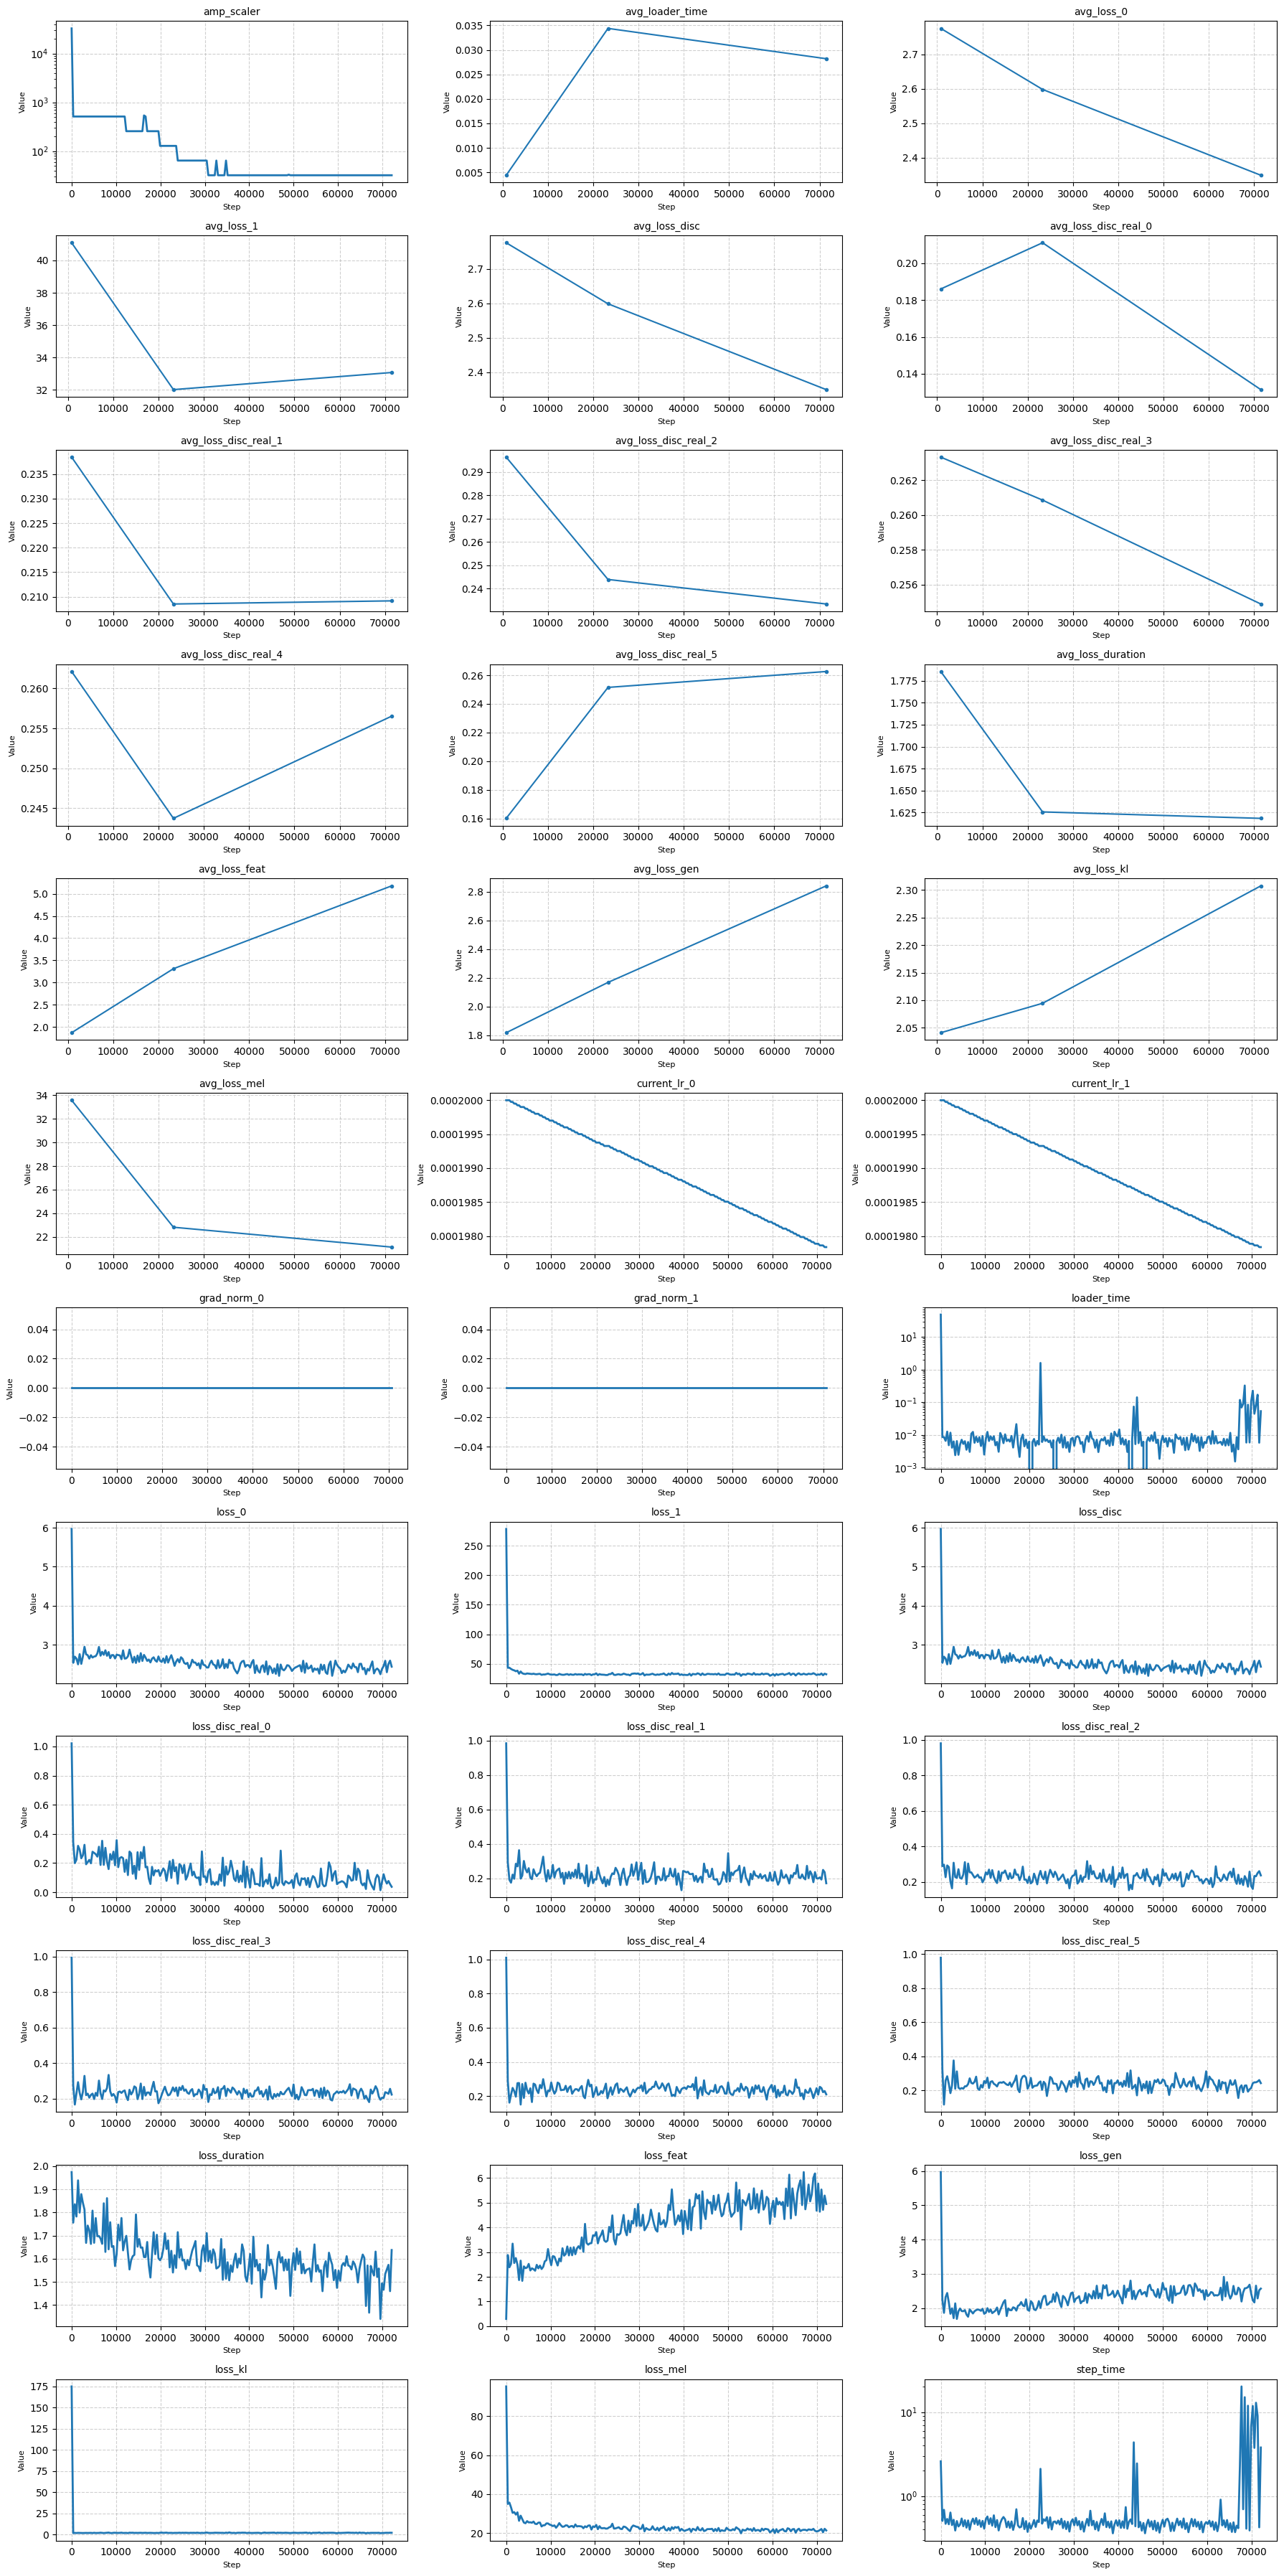

In [17]:
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# --- change this to your file path ---
file_path = "trainer_0_log.txt"

# Read file
with open(file_path, "r") as f:
    text = f.read()

# Regex to capture "name: value"
pattern = re.compile(r"\|\s*>\s*([\w\d_]+):\s*([-\d.eE]+)")

# Split text into blocks (each step)
blocks = text.strip().split("\n\n")

# Parse
all_data = []
for block in blocks:
    matches = pattern.findall(block)
    if matches:
        data_dict = {key: float(val) for key, val in matches}
        all_data.append(data_dict)

# Collect all metric names
all_keys = sorted({k for d in all_data for k in d.keys()})

# --- Plot in subplots ---
n_keys = len(all_keys)
cols = 3
rows = math.ceil(n_keys / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3))
axes = axes.flatten()

steps = np.arange(len(all_data))

for i, key in enumerate(all_keys):
    values = np.array([d.get(key, np.nan) for d in all_data])
    ax = axes[i]

    # drop NaNs
    mask = ~np.isnan(values)
    x = steps[mask]
    y = values[mask]

    if len(x) > 3:  # enough points for spline
        x_new = np.linspace(x.min(), x.max(), 200)
        spline = make_interp_spline(x, y, k=3)
        y_smooth = spline(x_new)
        ax.plot(x_new, y_smooth, linewidth=2, color="tab:blue")
    else:  # fallback: connect raw points
        ax.plot(x, y, linewidth=1.5, marker="o", markersize=3, color="tab:blue")

    ax.set_title(key, fontsize=10)
    ax.set_xlabel("Step", fontsize=8)
    ax.set_ylabel("Value", fontsize=8)
    ax.grid(True, linestyle="--", alpha=0.6)

    # Auto log-scale if huge value ranges
    finite_vals = y[y != 0]
    if len(finite_vals) > 0 and max(finite_vals) / (min(finite_vals) + 1e-9) > 1000:
        ax.set_yscale("log")

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("training_metrics.png", dpi=300)  # high-res PNG
plt.show()
